In [ ]:
import os
import pathlib
import numpy as np
from PIL import Image, ImageOps
from numpy import asarray

#Load the dataset
data_dir = r"./iris-dataset/"                             
data_dir = pathlib.Path(data_dir)
setosa = list(data_dir.glob('iris-setosa/*'))
versicolour = list(data_dir.glob('iris-versicolour/*'))
virginica = list(data_dir.glob('iris-virginica/*'))

print("No. of samples of setosa: ", len(setosa))
print("No. of samples of versicolour: ", len(versicolour))
print("No. of samples of virginica: ", len(virginica))

df_images = {
    'setosa' : setosa,
    'versicolour' : versicolour,
    'virginica': virginica
}

# numerical/integer labels for the categories
df_labels = {
    'setosa' : 0,
    'versicolour' : 1,
    'virginica': 2
}

No. of samples of setosa:  67
No. of samples of versicolour:  75
No. of samples of virginica:  85


In [2]:
# Data pre processing example on a single image
# Read image ---> Resize image ---> Convert to grayscale --> Normalize to (0,1) ---> Center image around 0 ---> Standardize the image (0 mean and unit variance)

image_path=df_images['setosa'][0]
print(f"Image path: {image_path}")
img = Image.open(str(image_path))
print("Size and type of the orignal image: ", img.size, img.mode)

resized_img = img.resize((64, 64))
gray_img= ImageOps.grayscale(resized_img)
print("Size and type of the resized image: ", gray_img.size, gray_img.mode)
new_img = asarray(gray_img)

## Normalization
# confirm pixel range is 0-255
print('Data Type: %s' % new_img.dtype)
print('Min: %.3f, Max: %.3f' % (new_img.min(), new_img.max()))
# convert from integers to floats
new_img = new_img.astype('float32')

# normalize to the range 0-1
new_img /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (new_img.min(), new_img.max()))

## Centering
# to center subtract the mean value from the pixel values.
# calculate global mean
mean = new_img.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (new_img.min(), new_img.max()))
# global centering of new_img
new_img = new_img - mean
# confirm it had the desired effect
mean = new_img.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (new_img.min(), new_img.max()))

## Standardization
#The distribution of pixel values often follows a Normal or Gaussian distribution, e.g. bell shape.
# calculate global mean and standard deviation
mean, std = new_img.mean(), new_img.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
# global standardization of new_img
new_img = (new_img - mean) / std
# confirm it had the desired effect
mean, std = new_img.mean(), new_img.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))

Image path: iris-dataset\iris-setosa\iris-01ab65973fd487a6cee4c5af1551c42b264eec5abab46bffd7c307ffef647e11.jpg
Size and type of the orignal image:  (256, 256) RGB
Size and type of the resized image:  (64, 64) L
Data Type: uint8
Min: 4.000, Max: 251.000
Min: 0.016, Max: 0.984
Mean: 0.459
Min: 0.016, Max: 0.984
Mean: 0.000
Min: -0.443, Max: 0.525
Mean: 0.000, Standard Deviation: 0.152
Mean: 0.000, Standard Deviation: 1.000


In [3]:
#Apply pre-processing to all the images and prepare the dataset
X, y = [], []                                             # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = Image.open(str(image))
        resized_img = img.resize((128, 128))               
        gray_img= ImageOps.grayscale(resized_img)
        new_img = asarray(gray_img)
        new_img = new_img.astype('float32')
        new_img /= 255.0
        mean = new_img.mean()
        new_img = new_img - mean
        mean, std = new_img.mean(), new_img.std()
        new_img = (new_img - mean) / std
        X.append(new_img) 
        y.append(df_labels[label])
X=np.array(X)
y=np.array(y)
print("Images: ", X.shape)
print("Labels:", y.shape)

Images:  (227, 128, 128)
Labels: (227,)


In [4]:
#Prepare training and testing dataset to develop the classifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

X_tr, X_te, Y_tr, Y_te = train_test_split(X, y, train_size = 0.8, random_state=42)    # 80% : training, 20%: testing
print("Number of train samples:", X_tr.shape)
print("Number of test samples:", X_te.shape)



Number of train samples: (181, 128, 128)
Number of test samples: (46, 128, 128)


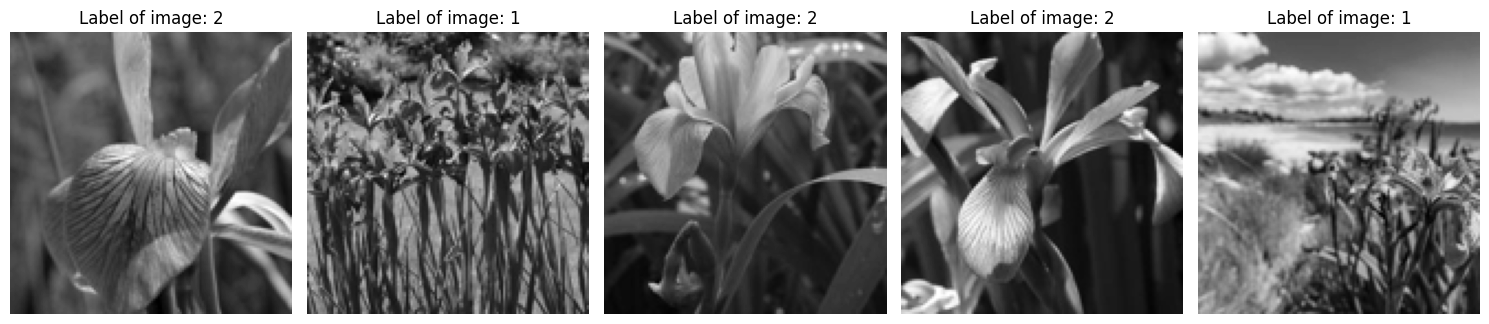

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

for i in range(1,6):
 plt.subplot(1,5,i)
 plt.imshow(X_tr[i,:,:],cmap='gray')
 plt.title('Label of image: {}'.format(Y_tr[i]))
 plt.axis('off')
 plt.tight_layout()
plt.show()

In [6]:
# Use the pixel values as features
X_train=X_tr.reshape(X_tr.shape[0],128*128)
X_test=X_te.reshape(X_te.shape[0],128*128)
print("Train data:", X_train.shape)
print("Test data: ", X_test.shape)

# identify outliers in the training dataset
# Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.
# It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.
# takes advantage of two anomalies’ quantitative properties: i) they are the minority consisting of fewer instances and ii) they have attribute-values that are very different from those of normal instances.

iso = IsolationForest(contamination=0.1, random_state=42)
#contamination” argument is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1.

yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
print(mask)
X_train_, Y_train_ = X_train[mask, :], Y_tr[mask]
print("Train data:", X_train_.shape)

Train data: (181, 16384)
Test data:  (46, 16384)
[ True  True False  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True False
  True  True  True  True  True False  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True False  True  True  True False  True  True False  True  True
  True  True  True  True False  True False  True  True  True  True  True
  True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  

[  2  13  55  59  65  74  84  88  99 110 114 117 124 126 133 138 159 176]


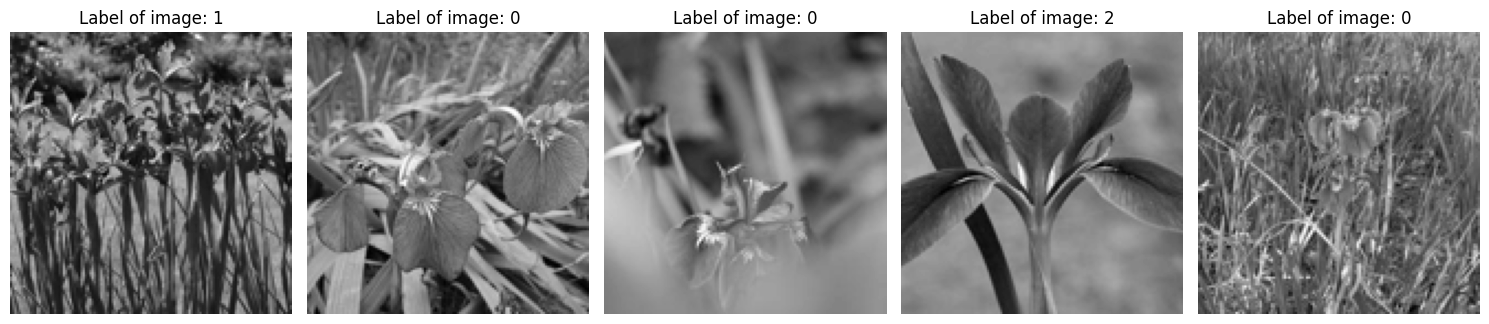

In [7]:
import matplotlib.pyplot as plt
indices=np.where(mask==False)[0]
print(indices)
plt.figure(figsize=(15,5))
j=0
for i in range(1,6):
 plt.subplot(1,5,i)
 plt.imshow(X_tr[indices[j],:,:],cmap='gray')
 plt.title('Label of image: {}'.format(Y_tr[indices[j]]))
 plt.axis('off')
 plt.tight_layout()
 j=j+1
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression

logreg =  LogisticRegression()
logreg.fit(X_train,Y_tr)

score = logreg.score(X_test, Y_te)
print(score)

0.41304347826086957
